# Session 1 - Normal Workflows

---
* Time: run all first time: ~ 3.5 minutes
* Time: run second time: ~ 1 minute
* Time: run and read step by step: ~ 40 minutes

---

In this tutorial we'll explore some normal workflows that require a bit more advanced use than the Hello BattMo tutorial. Within this tutorial you will:
- Learn how to create your own parameter sets
- Simulate a WLTP drive cycle to learn how to define your own parameter functions
- Implement electrode balancing to a simulation
- Investigate the influence of the reaction rate and diffusion coefficient on cell performance

Let's begin with importing BattMo and GLMakie.

In [30]:
using BattMo, GLMakie

GLMakie.activate!(inline=true) # Plotting figures will be rendered within the notebook

## Part 1 - Create your own parameter sets

This part of the tutorial walks you through the process of creating and customizing your own cell parameter sets in BattMo.jl. Cell parameter sets define the physical and chemical properties of the battery system you're simulating. You can build them from scratch using your model setup, modify them, and save them for future use.

The difficulty with setting up your own input parameters are that it's often not very clear which parameters you need for which submodel combination. In BattMo we have created a handy system to assist you in this process and bring more clearity in the parameter-model relations. We do this by providing functions that create empty parameter sets containing the required parameters based on the user's defined model setup.

Let's get into it!

### Step 1 - Initiate a model setup

First, define the battery model configuration you'd like to use. This will serve as the template for generating your parameter set. Model settings specify the submodels that the user would like to be included within the simulation. Have a quick look into the submodels that you can configure by running the following function.

In [31]:
print_submodels_info()

ℹ️  Submodels Information
Parameter                     Options                       Documentation
--------------------------------------------------------------------------------
CurrentCollectors             Generic                       -         
SEIModel                      Bolay                         [visit](https://battmoteam.github.io/BattMo.jl/dev/manuals/user_guide/sei_model)

RampUp                        Sinusoidal                    [visit](https://battmoteam.github.io/BattMo.jl/dev/manuals/user_guide/ramp_up)

TransportInSolid              FullDiffusion                 -         
ModelFramework                P2D, P4D Pouch                [visit](https://battmoteam.github.io/BattMo.jl/dev/manuals/user_guide/pxd_model)




Let's say we'd like to setup our own cell parameter set that includes parameters for a P2D simulation including SEI growth. Then we first configure the model. We can start from the default P2D model settings.

In [32]:
model_settings = load_model_settings(; from_file_path= "default_sets/model_settings/P2D.json")

{
    "RampUp" => "Sinusoidal"
    "Metadata" =>     {
        "Description" => "Default model settings for a P2D simulation including a current ramp up, excluding current collectors and SEI effects."
        "Title" => "P2D"
    }
    "TransportInSolid" => "FullDiffusion"
    "ModelFramework" => "P2D"
}

We can see that these settings don't include the SEI model. So let's add it. We can then instantiate the lithium ion battery model setup and see if our model settings are valid.

In [33]:

model_settings["SEIModel"] = "Bolay"

model_setup = LithiumIonBattery(; model_settings)

✔️ Validation of ModelSettings passed: No issues found.
──────────────────────────────────────────────────


LithiumIonBattery("Setup object for a P2D lithium-ion model", {
    "SEIModel" => "Bolay"
    "RampUp" => "Sinusoidal"
    "Metadata" =>     {
        "Description" => "Default model settings for a P2D simulation including a current ramp up, excluding current collectors and SEI effects."
        "Title" => "P2D"
    }
    "TransportInSolid" => "FullDiffusion"
    "ModelFramework" => "P2D"
}, true)

### Step 2 - load an empty parameter set

Next, create an empty parameter dictionary based on your model setup. This will include all the required keys but without any values filled in.

In [34]:
empty_cell_parameter_set = load_cell_parameters(; from_model_template = model_setup)

{
    "Electrolyte" =>     {
        "TransferenceNumber" => 0.0
        "DiffusionCoefficient" => 0.0
        "IonicConductivity" => 0.0
        "Density" => 0.0
        "ChargeNumber" => 0.0
        "Concentration" => 0.0
    }
    "Cell" =>     {
        "ElectrodeGeometricSurfaceArea" => 0.0
        "Case" => ""
    }
    "PositiveElectrode" =>     {
        "ActiveMaterial" =>         {
            "ActivationEnergyOfDiffusion" => 0.0
            "NumberOfElectronsTransfered" => 0.0
            "StoichiometricCoefficientAtSOC0" => 0.0
            "OpenCircuitPotential" => 0.0
            "ReactionRateConstant" => 0.0
            "MassFraction" => 0.0
            "StoichiometricCoefficientAtSOC100" => 0.0
            "ActivationEnergyOfReaction" => 0.0
            "MaximumConcentration" => 0.0
            "VolumetricSurfaceArea" => 0.0
            "DiffusionCoefficient" => 0.0
            "ParticleRadius" => 0.0
            "Density" => 0.0
            "ElectronicConductivity" => 0

### Step 3 - Save the empty set to a JSON file

You can now write this empty set to a JSON file so you can alter it and reuse it later on. 

In [35]:
file_path = "my_custom_parameters.json"
write_to_json_file(file_path, empty_cell_parameter_set)

Data successfully written to my_custom_parameters.json


### Step 4 - Let BattMo help you fill the empty set

If you're unsure about what a specific parameter means or how it should be formatted, BattMo provides a helpful function to inspect any parameter.

In [36]:
print_parameter_info("OpenCircuitPotential")

ℹ️  Parameter Information
🔹 Name:         	OpenCircuitPotential
🔹 Description:		The open-circuit potential of the active material under a given intercalant stoichimetry and temperature.
🔹 Type:         	String, Dict{String, Vector}, Real
🔹 Unit:         	V
🔹 Documentation:	[visit](https://battmoteam.github.io/BattMo.jl/dev/manuals/user_guide/simulation_dependent_input)

🔹 Ontology link:	[visit](https://w3id.org/emmo/domain/electrochemistry#electrochemistry_9c657fdc_b9d3_4964_907c_f9a6e8c5f52b)




In [37]:
print_parameter_info("concentration")

ℹ️  Parameter Information
🔹 Name:         	InterstitialConcentration
🔹 Description:		Amount of neutral intersticial sites of the intercalant (Li+) per volume of solid. See https://doi.org/10.1002/cssc.201800077.
🔹 Type:         	Real
🔹 Unit:         	mol·m⁻³
🔹 Minimum value:      	0.0
🔹 Maximum value:      	100000.0
🔹 Documentation:	-
🔹 Ontology link:	-

ℹ️  Parameter Information
🔹 Name:         	MaximumConcentration
🔹 Description:		The saturation concentration of the guest molecule in the host material
🔹 Type:         	Real
🔹 Unit:         	mol·m⁻³
🔹 Minimum value:      	0.0
🔹 Maximum value:      	1.0e6
🔹 Documentation:	-
🔹 Ontology link:	[visit](https://w3id.org/emmo/domain/electrochemistry#electrochemistry_47287d09_6108_45ca_ac65_8b9451b1065e)


ℹ️  Parameter Information
🔹 Name:         	Concentration
🔹 Description:		Moles of the charge carrier species per cubic meter of electrolyte.
🔹 Type:         	Real
🔹 Unit:         	mol·m⁻³
🔹 Minimum value:      	0.0
🔹 Maximum value:      	500

The automatic validation when initiating the Simulation object can help you keep track of your progress on filling in the parameter values and find any values that are unrealistic.

In [38]:
cell_parameters = load_cell_parameters(; from_file_path= "my_custom_parameters.json")


sim = Simulation(model_setup, cell_parameters, load_cycling_protocol(;from_default_set= "CCDischarge"));

🔍 Validation of CellParameters failed with 42 issues:

──────────────────────────────────────────────────
──────────────────────────────────────────────────
Issue 1:
📍 Where:       [Electrolyte][TransferenceNumber]
🔢 Provided:    0.0
🔑 Rule:        minimum = 0.01
🛠  Issue:       Value is below the minimum allowed (0.01)

──────────────────────────────────────────────────
Issue 2:
📍 Where:       [Electrolyte][Density]
🔢 Provided:    0.0
🔑 Rule:        minimum = 0.01
🛠  Issue:       Value is below the minimum allowed (0.01)

──────────────────────────────────────────────────
Issue 3:
📍 Where:       [Electrolyte][ChargeNumber]
🔢 Provided:    0.0
🔑 Rule:        minimum = 1
🛠  Issue:       Value is below the minimum allowed (1)

──────────────────────────────────────────────────
Issue 4:
📍 Where:       [Cell][ElectrodeGeometricSurfaceArea]
🔢 Provided:    0.0
🔑 Rule:        minimum = 0.0001
🛠  Issue:       Value is below the minimum allowed (0.0001)

─────────────────────────────────────────

Now you know how you can create your own input files! 

## Part 2 - Create your own parameter function

For some parameters you can define you own function in a Julia script and pass it to BattMo. This is available for the following parameters:

**Cell parameters**
- OpenCircuitPotential (negative and positive electrode)
- DiffusionCoefficient (electrolyte)
- Conductivity (electrolyte)

**Cycling protocol parameters**
- Current

Let have a look into how we can implement this.

 ### Cell parameters

For the cell parameters we can have a look at the default cell parameter set "Xu2015.json". Open this parameter set and have a look at how the open circuit potential is defined.

In [39]:
cell_parameters = load_cell_parameters(; from_file_path = "default_sets/cell_parameters/Xu2015.json")

cell_parameters["NegativeElectrode"]["ActiveMaterial"]["OpenCircuitPotential"]

Dict{String, Any} with 2 entries:
  "FilePath"     => "function_parameters_Xu2015.jl"
  "FunctionName" => "open_circuit_potential_graphite_Xu_2015"

We can see that the OpenCircuitPotential in this case has a value of type Dict containing the following keys:
- **FilePath**: the path to the julia script containing the function (relative to the json file)
- **FunctionName**: the name of the function

When running a simulation, BattMo will be able to access the julia script and import the functions defined within that script into the name space so that they can be used for calculating the quantity internally.

An even easier way to do it is to define a function, doesn't matter where, and import it into Main which is the namespace that BattMo can access during a simulation. You can then either define the function within the main script that you're running or define it in a separate script and include that script into your main script.

Let's go through a fun example for setting up your own current function to see how you put this into practice.

### Current function

For this example we'll use Worldwide harmonized Light vehicles Test Procedure (WLTP) drive cycle data that is stored within "wltp_data/wltp.csv". In order to create a current function from this data we'll have to undergo a couple of steps:
1. Read the time and power data from the CSV.
2. Create an interpolation object from the data.
3. Define a function that returns the current calculated from the interpolated object.
4. Import the function into the Main module.

The following code describes these four steps. Running this script will create the function and import it into Main so that BattMo can access it. If you'd like more structure in your files or keep the input functions separate from your main script, you can define the code into a separate Julia file and use `include("curren_function_script.jl")` to import the function into you main script.

In [40]:
####################################################################################################
# An example of a user defined current function using WLTP data from https://github.com/JRCSTU/wltp

using CSV:CSV
using DataFrames
using Jutul:Jutul

# 1. Read data
path = joinpath(@__DIR__, "wltp.csv")
df = CSV.read(path, DataFrame)

t = df[:, 1]
P = df[:, 2]


# 2. Use a Jutul interpolator to create an interpolation object of the time and power data
power_func = Jutul.get_1d_interpolator(t, P, cap_endpoints = false)


# 3. Define a function to calculate the current. The current function has to accept time and voltage as arguments.
function wltp_current(time, voltage)

	factor = 4000 # Tot account for the fact that we're simulating a single cell instead of a battery pack

	return power_func(time) / voltage / factor
end


# 4. Import the function into Main
@eval Main wltp_current = $wltp_current

wltp_current (generic function with 1 method)

Now that we have imported our function into Main, we need to create a cycling protocol parameter file that passes the function name to BattMo. The cycling protocols in BattMo are categorized by the parameter "Protocol". Let's get a bit more information on the parameter.

In [41]:
print_parameter_info("Protocol")

ℹ️  Parameter Information
🔹 Name:         	Protocol
🔹 Description:		Type of cycling procedure used to cycle a cell. For instance: Constant Current ("CC"), Constant Current - Constant Voltage ("CCCV").
🔹 Type:         	String
🔹 Options:      	CC, CCCV, Function
🔹 Documentation:	-
🔹 Ontology link:	[visit](https://w3id.org/emmo/domain/electrochemistry#electrochemistry_d3e2d213_d078_4b9a_8beb_62f063e57d69)




We can see that the paramater Protocol can have three different values: CC, CCCV, or Function. In our case, we want to define our own current function so we'll need to specify Protocol as "Function". Let's use the default cycling protocol parameter set "user_defined_current_function.json" and adapt it to our case.

In [42]:
current_function = load_cycling_protocol(; from_file_path = "default_sets/cycling_protocols/user_defined_current_function.json")

{
    "TotalTime" => 1800
    "FunctionName" => "current_function"
    "InitialStateOfCharge" => 0.99
    "InitialTemperature" => 298.15
    "Metadata" =>     {
        "Description" => "Parameter set that shows an example of how to include a user defined function in the cycling protocol parameters."
        "Title" => "user_defined_current_function"
    }
    "Protocol" => "Function"
}

We need to change the function name. The other parameters we can leave them as they are for now.

In [43]:
current_function["FunctionName"] = "wltp_current"

"wltp_current"

We can now write the altered cycling protocol data to a new json file so that we can reuse it in the future.

In [44]:
file_path = "default_sets/cycling_protocols/wltp_protocol.json"
write_to_json_file(file_path, current_function)

Data successfully written to default_sets/cycling_protocols/wltp_protocol.json


Now we can run a simulation using the json file we just created as input for the cycling protocol

✔️ Validation of ModelSettings passed: No issues found.
──────────────────────────────────────────────────
✔️ Validation of CellParameters passed: No issues found.
──────────────────────────────────────────────────
✔️ Validation of CyclingProtocol passed: No issues found.
──────────────────────────────────────────────────
✔️ Validation of SimulationSettings passed: No issues found.
──────────────────────────────────────────────────
Jutul: Simulating 30 minutes as 36 report steps
╭────────────────┬──────────┬──────────────┬──────────╮
│ Iteration type │ Avg/step │ Avg/ministep │    Total │
│                │ 36 steps │ 36 ministeps │ (wasted) │
├────────────────┼──────────┼──────────────┼──────────┤
│ Newton         │  3.27778 │      3.27778 │  118 (0) │
│ Linearization  │  4.27778 │      4.27778 │  154 (0) │
│ Linear solver  │  3.27778 │      3.27778 │  118 (0) │
│ Precond apply  │      0.0 │          0.0 │    0 (0) │
╰────────────────┴──────────┴──────────────┴──────────╯
╭───────────

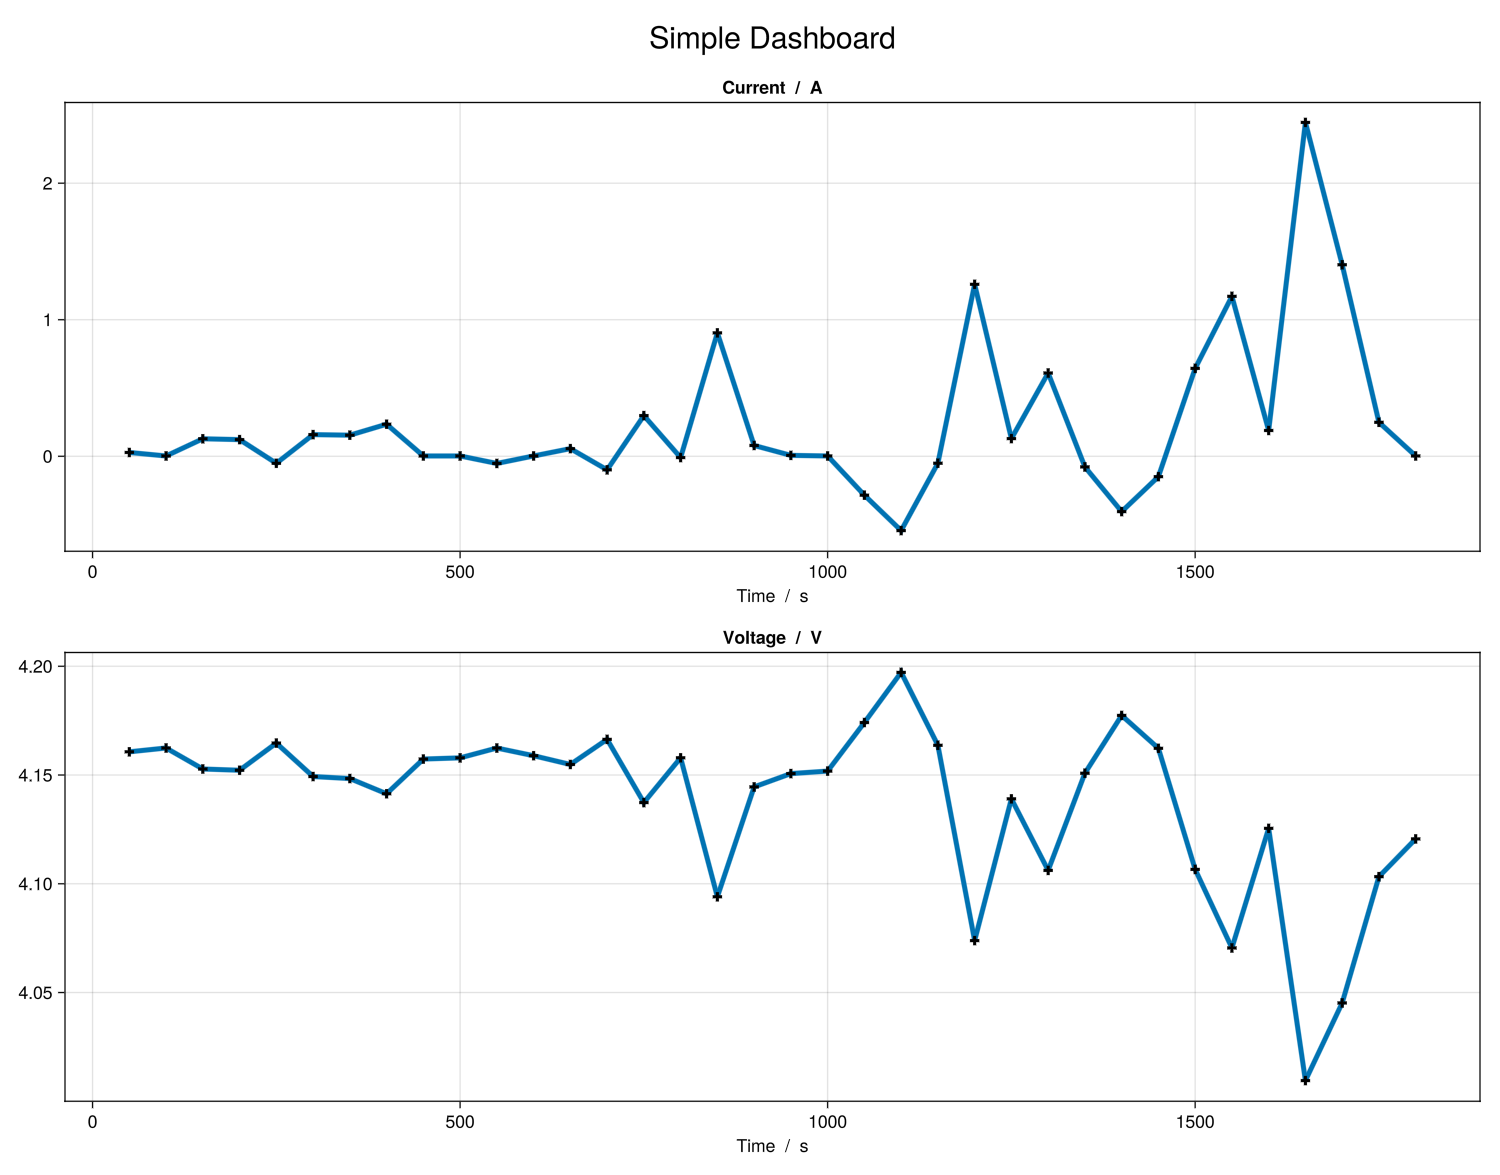

In [45]:

cell_parameters = load_cell_parameters(; from_file_path = "default_sets/cell_parameters/Chen2020.json")
cycling_protocol = load_cycling_protocol(; from_file_path= "default_sets/cycling_protocols/wltp_protocol.json")

model_setup = LithiumIonBattery()

sim = Simulation(model_setup, cell_parameters, cycling_protocol);

output = solve(sim);

plot_dashboard(output)

We can see that the output curves don't look smooth at all. Probably our time resolution isn't small enough. Let's look into changing the simulation setting that determines this. We can print the time related settings to find the right setting that we need to alter.

In [46]:
print_setting_info("time")

ℹ️  Setting Information
🔹 Name:         	TimeStepDuration
🔹 Description:		Duration of each time step in simulations
🔹 Type:         	Real
🔹 Unit:         	s
🔹 Minimum value:      	1
🔹 Maximum value:      	500
🔹 Documentation:	-
🔹 Ontology link:	[visit](https://w3id.org/emmo/domain/electrochemistry#electrochemistry_85e39686_9658_4c74_bb91_a935704c174a)


ℹ️  Setting Information
🔹 Name:         	RampUpTime
🔹 Description:		Ramp up time duration applied to initialize the cell simulation.
🔹 Type:         	Int64
🔹 Unit:         	s
🔹 Minimum value:      	0
🔹 Maximum value:      	500
🔹 Documentation:	-
🔹 Ontology link:	-



We can see that the time step duration is the one we need. Until now, we have only used the default simulation settings. Let's see what the default value of the "TimeStepDuration" is.

In [47]:
sim.simulation_settings["TimeStepDuration"]

50

It is equal to 50 seconds. Let's refine the time resolution and set it to 1 second. We need to load the default simulation settings first.

In [48]:
simulation_settings = load_simulation_settings(; from_file_path = "default_sets/simulation_settings/P2D.json")
simulation_settings["TimeStepDuration"] = 1

1

We can pass the simulation settings to the Simulation object and run the new simulation.

✔️ Validation of CellParameters passed: No issues found.
──────────────────────────────────────────────────
✔️ Validation of CyclingProtocol passed: No issues found.
──────────────────────────────────────────────────
✔️ Validation of SimulationSettings passed: No issues found.
──────────────────────────────────────────────────
Jutul: Simulating 30 minutes as 1800 report steps


Progress   5%|███                                        |  ETA: 0:00:04

Progress   9%|█████                                      |  ETA: 0:00:03

Progress  13%|██████                                     |  ETA: 0:00:03

Progress  15%|███████                                    |  ETA: 0:00:03

Progress  17%|████████                                   |  ETA: 0:00:04

Progress  20%|█████████                                  |  ETA: 0:00:03

Progress  22%|██████████                                 |  ETA: 0:00:03

Progress  25%|███████████                                |  ETA: 0:00:03

Progress  31%|██████████████                             |  ETA: 0:00:03

Progress  34%|███████████████                            |  ETA: 0:00:03

Progress  37%|█████████████████                          |  ETA: 0:00:02

Progress  40%|██████████████████                         |  ETA: 0:00:02

Progress  42%|███████████████████                        |  ETA: 0:00:02

Progress  44%|███████████████████     

╭────────────────┬────────────┬────────────────┬──────────╮
│ Iteration type │   Avg/step │   Avg/ministep │    Total │
│                │ 1800 steps │ 1800 ministeps │ (wasted) │
├────────────────┼────────────┼────────────────┼──────────┤
│ Newton         │    2.70444 │        2.70444 │ 4868 (0) │
│ Linearization  │    3.70444 │        3.70444 │ 6668 (0) │
│ Linear solver  │    2.70444 │        2.70444 │ 4868 (0) │
│ Precond apply  │        0.0 │            0.0 │    0 (0) │
╰────────────────┴────────────┴────────────────┴──────────╯
╭───────────────┬──────────┬────────────┬────────╮
│ Timing type   │     Each │   Relative │  Total │
│               │       μs │ Percentage │      s │
├───────────────┼──────────┼────────────┼────────┤
│ Properties    │  42.0681 │     4.40 % │ 0.2048 │
│ Equations     │ 152.5988 │    21.87 % │ 1.0175 │
│ Assembly      │  68.0612 │     9.75 % │ 0.4538 │
│ Linear solve  │ 314.6434 │    32.92 % │ 1.5317 │
│ Linear setup  │   0.0000 │     0.00 % │ 0.0000 │
│

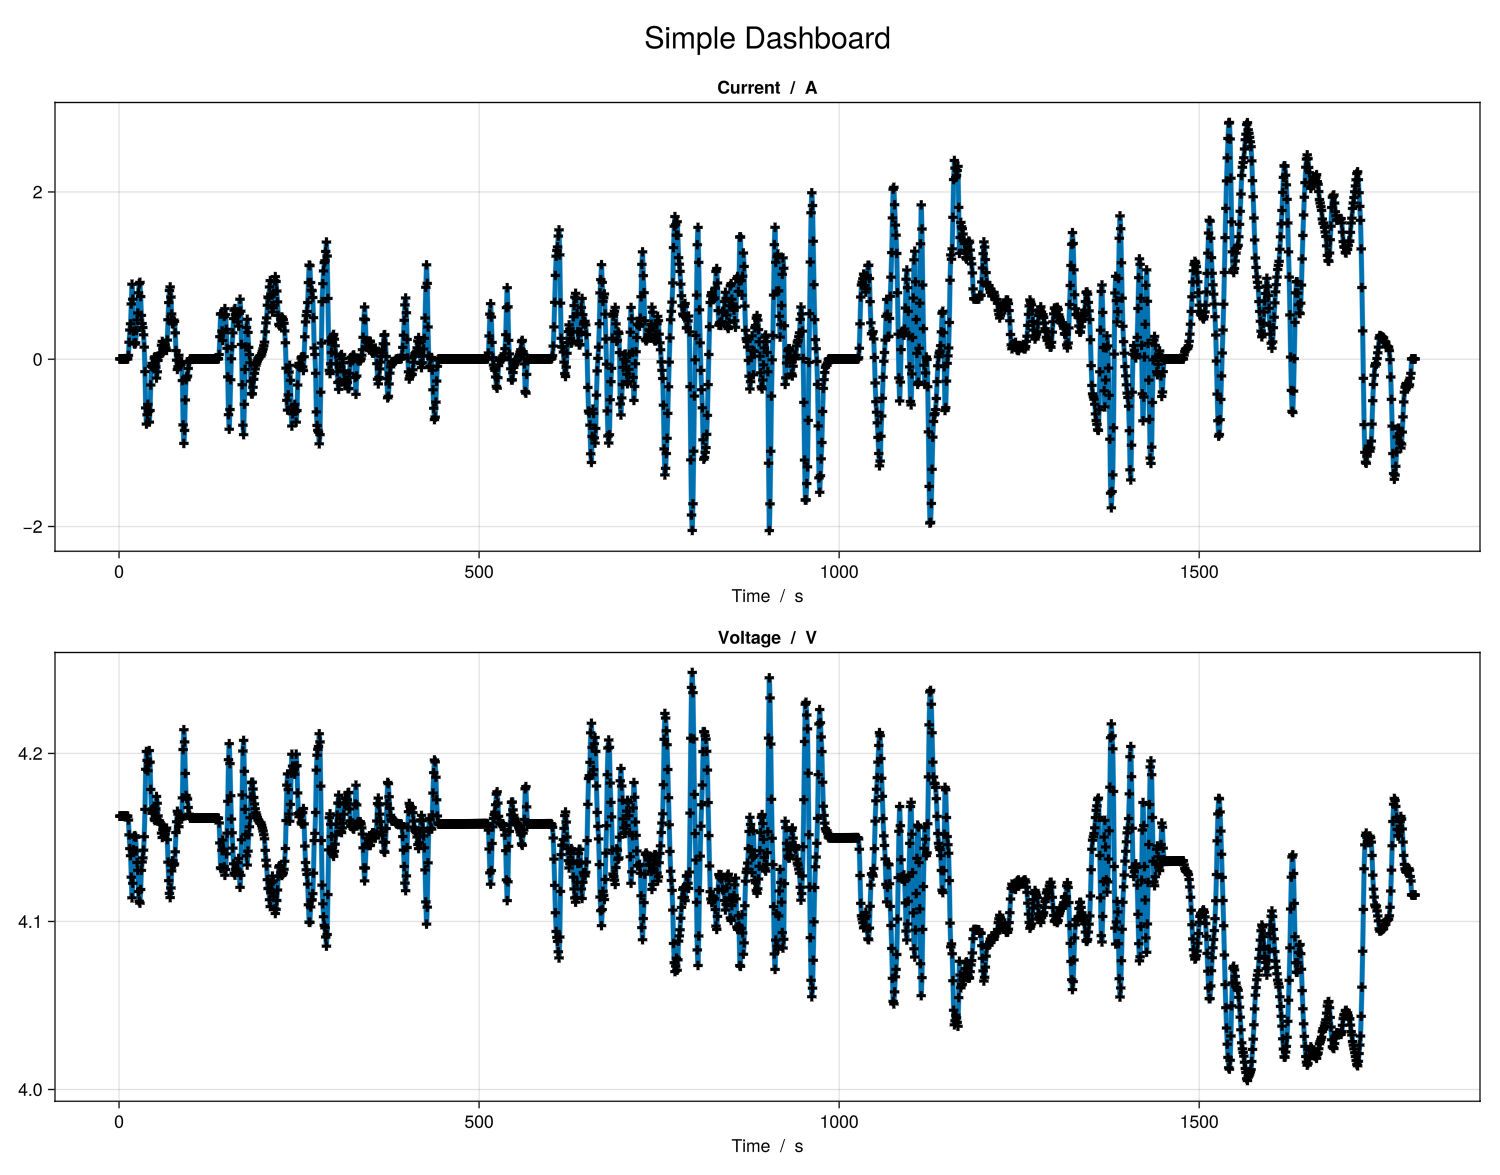

In [49]:
sim = Simulation(model_setup, cell_parameters, cycling_protocol; simulation_settings);

output = solve(sim);

plot_dashboard(output)


## Part 3 - Electrode balancing

In this tutorial, we will study the effects that electrode thicknesses have over the power delivered by a cell. Power capability is usually determined from the
loss in capacity when cycling the cell at higher rates. We will compare the effects of thickness on the power delivery of a cell. Let's load some default parameter sets and model settings.

In [50]:
cell_parameters = load_cell_parameters(; from_file_path = "default_sets/cell_parameters/Chen2020.json")
cc_discharge_protocol = load_cycling_protocol(; from_file_path = "default_sets/cycling_protocols/CCDischarge.json")

model_setup = LithiumIonBattery()

✔️ Validation of ModelSettings passed: No issues found.
──────────────────────────────────────────────────


LithiumIonBattery("Setup object for a P2D lithium-ion model", {
    "RampUp" => "Sinusoidal"
    "Metadata" =>     {
        "Description" => "Default model settings for a P2D simulation including a current ramp up, excluding current collectors and SEI effects."
        "Title" => "P2D"
    }
    "TransportInSolid" => "FullDiffusion"
    "ModelFramework" => "P2D"
}, true)

We will change the thickness of the positive electrode, and evaluate the cell capacity at different CRates. Lets define the DRates to use and the range of thicknesses to explore.

In [51]:
d_rates = [0.05, 0.1, 0.2, 0.5, 1.0, 2.0, 2.5]
thicknesses = range(8.0e-5, 11.0e-5, length = 9)

8.0e-5:3.75e-6:0.00011

Now we loop through both DRates and thicknesses to run a simulation for each combination. For each simulation, we will calculate the discharge capacity, and store it for plotting.

In [52]:
power_rates = []
np_ratios = []

for thickness in thicknesses

	capacities = []
	
	cell_parameters["NegativeElectrode"]["ElectrodeCoating"]["Thickness"] = thickness
	n_to_p_ratio = compute_np_ratio(cell_parameters)
	push!(np_ratios, n_to_p_ratio)

	for d_rate in d_rates

		cc_discharge_protocol["DRate"] = d_rate
		sim = Simulation(model_setup, cell_parameters, cc_discharge_protocol)
		print("###### Simulation of thickness $thickness | d_rate $d_rate #########")
		output = solve(sim; end_report = false)

		if length(output[:states]) > 0 # if simulation is successful
			discharge_capacity = compute_discharge_capacity(output)
			push!(capacities, discharge_capacity)
		else
			push!(capacities, 0.0)
		end
	end
	push!(power_rates, (thickness = thickness, d_rates = d_rates, capacities = capacities, np_ratios = n_to_p_ratio))
end

✔️ Validation of CellParameters passed: No issues found.
──────────────────────────────────────────────────
✔️ Validation of CyclingProtocol passed: No issues found.
──────────────────────────────────────────────────
✔️ Validation of SimulationSettings passed: No issues found.
──────────────────────────────────────────────────
###### Simulation of thickness 8.0e-5 | d_rate 0.05 #########Jutul: Simulating 22 hours as 1589 report steps


Progress   5%|███                                        |  ETA: 0:00:02

Progress   9%|█████                                      |  ETA: 0:00:02

Progress  16%|███████                                    |  ETA: 0:00:02

Progress  22%|██████████                                 |  ETA: 0:00:02

Progress  28%|████████████                               |  ETA: 0:00:02

Progress  33%|███████████████                            |  ETA: 0:00:01

Progress  38%|█████████████████                          |  ETA: 0:00:01

Progress  43%|███████████████████                        |  ETA: 0:00:01

Progress  49%|█████████████████████                      |  ETA: 0:00:01

Progress  54%|████████████████████████                   |  ETA: 0:00:01

Progress  59%|██████████████████████████                 |  ETA: 0:00:01

Progress  66%|█████████████████████████████              |  ETA: 0:00:01

Progress  74%|████████████████████████████████           |  ETA: 0:00:01

Progress  82%|████████████████████████

✔️ Validation of CellParameters passed: No issues found.
──────────────────────────────────────────────────
✔️ Validation of CyclingProtocol passed: No issues found.
──────────────────────────────────────────────────
✔️ Validation of SimulationSettings passed: No issues found.
──────────────────────────────────────────────────
###### Simulation of thickness 8.0e-5 | d_rate 0.1 #########Jutul: Simulating 11 hours as 797 report steps


Progress  11%|█████                                      |  ETA: 0:00:01

Progress  24%|███████████                                |  ETA: 0:00:01

Progress  35%|███████████████                            |  ETA: 0:00:01

Progress  44%|████████████████████                       |  ETA: 0:00:01

Progress  57%|█████████████████████████                  |  ETA: 0:00:00

Progress  67%|█████████████████████████████              |  ETA: 0:00:00

Progress  78%|██████████████████████████████████         |  ETA: 0:00:00

Progress  87%|██████████████████████████████████████     |  ETA: 0:00:00

Progress 100%|███████████████████████████████████████████| Time: 0:00:01


✔️ Validation of CellParameters passed: No issues found.
──────────────────────────────────────────────────
✔️ Validation of CyclingProtocol passed: No issues found.
──────────────────────────────────────────────────
✔️ Validation of SimulationSettings passed: No issues found.
──────────────────────────────────────────────────
###### Simulation of thickness 8.0e-5 | d_rate 0.2 #########Jutul: Simulating 5 hours, 30 minutes as 401 report steps


Progress  26%|████████████                               |  ETA: 0:00:00

Progress  48%|█████████████████████                      |  ETA: 0:00:00

Progress  77%|██████████████████████████████████         |  ETA: 0:00:00

Progress 100%|███████████████████████████████████████████| Time: 0:00:00


✔️ Validation of CellParameters passed: No issues found.
──────────────────────────────────────────────────
✔️ Validation of CyclingProtocol passed: No issues found.
──────────────────────────────────────────────────
✔️ Validation of SimulationSettings passed: No issues found.
──────────────────────────────────────────────────
###### Simulation of thickness 8.0e-5 | d_rate 0.5 #########Jutul: Simulating 2 hours, 12 minutes as 163 report steps


Progress  25%|███████████                                |  ETA: 0:00:00

Progress  76%|█████████████████████████████████          |  ETA: 0:00:00

Progress 100%|███████████████████████████████████████████| Time: 0:00:00


✔️ Validation of CellParameters passed: No issues found.
──────────────────────────────────────────────────
✔️ Validation of CyclingProtocol passed: No issues found.
──────────────────────────────────────────────────
✔️ Validation of SimulationSettings passed: No issues found.
──────────────────────────────────────────────────
###### Simulation of thickness 8.0e-5 | d_rate 1.0 #########Jutul: Simulating 1 hour, 6 minutes as 84 report steps


Progress  58%|█████████████████████████                  |  ETA: 0:00:00

Progress 100%|███████████████████████████████████████████| Time: 0:00:00


✔️ Validation of CellParameters passed: No issues found.
──────────────────────────────────────────────────
✔️ Validation of CyclingProtocol passed: No issues found.
──────────────────────────────────────────────────
✔️ Validation of SimulationSettings passed: No issues found.
──────────────────────────────────────────────────
###### Simulation of thickness 8.0e-5 | d_rate 2.0 #########Jutul: Simulating 33 minutes, 0.0002274 nanoseconds as 44 report steps
✔️ Validation of CellParameters passed: No issues found.
──────────────────────────────────────────────────
✔️ Validation of CyclingProtocol passed: No issues found.
──────────────────────────────────────────────────
✔️ Validation of SimulationSettings passed: No issues found.
──────────────────────────────────────────────────
###### Simulation of thickness 8.0e-5 | d_rate 2.5 #########Jutul: Simulating 26 minutes, 24 seconds as 36 report steps
✔️ Validation of CellParameters passed: No issues found.
──────────────────────────────────

Progress   5%|███                                        |  ETA: 0:00:02

Progress  10%|█████                                      |  ETA: 0:00:02

Progress  14%|███████                                    |  ETA: 0:00:02

Progress  19%|█████████                                  |  ETA: 0:00:02

Progress  25%|███████████                                |  ETA: 0:00:02

Progress  31%|██████████████                             |  ETA: 0:00:02

Progress  37%|████████████████                           |  ETA: 0:00:01

Progress  43%|███████████████████                        |  ETA: 0:00:01

Progress  48%|█████████████████████                      |  ETA: 0:00:01

Progress  54%|████████████████████████                   |  ETA: 0:00:01

Progress  60%|██████████████████████████                 |  ETA: 0:00:01

Progress  66%|█████████████████████████████              |  ETA: 0:00:01

Progress  75%|█████████████████████████████████          |  ETA: 0:00:01

Progress  82%|████████████████████████

✔️ Validation of CellParameters passed: No issues found.
──────────────────────────────────────────────────
✔️ Validation of CyclingProtocol passed: No issues found.
──────────────────────────────────────────────────
✔️ Validation of SimulationSettings passed: No issues found.
──────────────────────────────────────────────────
###### Simulation of thickness 8.375e-5 | d_rate 0.1 #########Jutul: Simulating 11 hours as 797 report steps


Progress   9%|████                                       |  ETA: 0:00:02

Progress  18%|████████                                   |  ETA: 0:00:01

Progress  29%|█████████████                              |  ETA: 0:00:01

Progress  39%|█████████████████                          |  ETA: 0:00:02

Progress  50%|██████████████████████                     |  ETA: 0:00:01

Progress  61%|███████████████████████████                |  ETA: 0:00:01

Progress  72%|███████████████████████████████            |  ETA: 0:00:01

Progress  82%|████████████████████████████████████       |  ETA: 0:00:00

Progress 100%|███████████████████████████████████████████| Time: 0:00:01


✔️ Validation of CellParameters passed: No issues found.
──────────────────────────────────────────────────
✔️ Validation of CyclingProtocol passed: No issues found.
──────────────────────────────────────────────────
✔️ Validation of SimulationSettings passed: No issues found.
──────────────────────────────────────────────────
###### Simulation of thickness 8.375e-5 | d_rate 0.2 #########Jutul: Simulating 5 hours, 30 minutes as 401 report steps


Progress  11%|█████                                      |  ETA: 0:00:01

Progress  30%|██████████████                             |  ETA: 0:00:01

Progress  53%|███████████████████████                    |  ETA: 0:00:00

Progress  74%|████████████████████████████████           |  ETA: 0:00:00

Progress 100%|███████████████████████████████████████████| Time: 0:00:00


✔️ Validation of CellParameters passed: No issues found.
──────────────────────────────────────────────────
✔️ Validation of CyclingProtocol passed: No issues found.
──────────────────────────────────────────────────
✔️ Validation of SimulationSettings passed: No issues found.
──────────────────────────────────────────────────
###### Simulation of thickness 8.375e-5 | d_rate 0.5 #########Jutul: Simulating 2 hours, 12 minutes as 163 report steps


Progress  41%|██████████████████                         |  ETA: 0:00:00

Progress  82%|████████████████████████████████████       |  ETA: 0:00:00

Progress 100%|███████████████████████████████████████████| Time: 0:00:00


✔️ Validation of CellParameters passed: No issues found.
──────────────────────────────────────────────────
✔️ Validation of CyclingProtocol passed: No issues found.
──────────────────────────────────────────────────
✔️ Validation of SimulationSettings passed: No issues found.
──────────────────────────────────────────────────
###### Simulation of thickness 8.375e-5 | d_rate 1.0 #########Jutul: Simulating 1 hour, 6 minutes as 84 report steps


Progress  72%|███████████████████████████████            |  ETA: 0:00:00

Progress 100%|███████████████████████████████████████████| Time: 0:00:00


✔️ Validation of CellParameters passed: No issues found.
──────────────────────────────────────────────────
✔️ Validation of CyclingProtocol passed: No issues found.
──────────────────────────────────────────────────
✔️ Validation of SimulationSettings passed: No issues found.
──────────────────────────────────────────────────
###### Simulation of thickness 8.375e-5 | d_rate 2.0 #########Jutul: Simulating 33 minutes, 0.0002274 nanoseconds as 44 report steps
✔️ Validation of CellParameters passed: No issues found.
──────────────────────────────────────────────────
✔️ Validation of CyclingProtocol passed: No issues found.
──────────────────────────────────────────────────
✔️ Validation of SimulationSettings passed: No issues found.
──────────────────────────────────────────────────
###### Simulation of thickness 8.375e-5 | d_rate 2.5 #########Jutul: Simulating 26 minutes, 24 seconds as 36 report steps
✔️ Validation of CellParameters passed: No issues found.
──────────────────────────────

Progress   3%|██                                         |  ETA: 0:00:04

Progress   8%|████                                       |  ETA: 0:00:02

Progress  14%|██████                                     |  ETA: 0:00:02

Progress  19%|█████████                                  |  ETA: 0:00:02

Progress  24%|███████████                                |  ETA: 0:00:02

Progress  30%|█████████████                              |  ETA: 0:00:02

Progress  35%|████████████████                           |  ETA: 0:00:01

Progress  41%|██████████████████                         |  ETA: 0:00:01

Progress  47%|█████████████████████                      |  ETA: 0:00:01

Progress  52%|███████████████████████                    |  ETA: 0:00:01

Progress  57%|█████████████████████████                  |  ETA: 0:00:01

Progress  64%|████████████████████████████               |  ETA: 0:00:01

Progress  74%|████████████████████████████████           |  ETA: 0:00:01

Progress  80%|████████████████████████

✔️ Validation of CellParameters passed: No issues found.
──────────────────────────────────────────────────
✔️ Validation of CyclingProtocol passed: No issues found.
──────────────────────────────────────────────────
✔️ Validation of SimulationSettings passed: No issues found.
──────────────────────────────────────────────────
###### Simulation of thickness 8.75e-5 | d_rate 0.1 #########Jutul: Simulating 11 hours as 797 report steps


Progress  11%|█████                                      |  ETA: 0:00:01

Progress  21%|█████████                                  |  ETA: 0:00:01

Progress  33%|███████████████                            |  ETA: 0:00:01

Progress  45%|████████████████████                       |  ETA: 0:00:01

Progress  58%|█████████████████████████                  |  ETA: 0:00:00

Progress  68%|██████████████████████████████             |  ETA: 0:00:00

Progress  78%|██████████████████████████████████         |  ETA: 0:00:00

Progress  87%|██████████████████████████████████████     |  ETA: 0:00:00

Progress 100%|███████████████████████████████████████████| Time: 0:00:01


✔️ Validation of CellParameters passed: No issues found.
──────────────────────────────────────────────────
✔️ Validation of CyclingProtocol passed: No issues found.
──────────────────────────────────────────────────
✔️ Validation of SimulationSettings passed: No issues found.
──────────────────────────────────────────────────
###### Simulation of thickness 8.75e-5 | d_rate 0.2 #########Jutul: Simulating 5 hours, 30 minutes as 401 report steps


Progress  21%|█████████                                  |  ETA: 0:00:00

Progress  41%|██████████████████                         |  ETA: 0:00:00

Progress  66%|█████████████████████████████              |  ETA: 0:00:00

Progress  90%|███████████████████████████████████████    |  ETA: 0:00:00

Progress 100%|███████████████████████████████████████████| Time: 0:00:00


✔️ Validation of CellParameters passed: No issues found.
──────────────────────────────────────────────────
✔️ Validation of CyclingProtocol passed: No issues found.
──────────────────────────────────────────────────
✔️ Validation of SimulationSettings passed: No issues found.
──────────────────────────────────────────────────
###### Simulation of thickness 8.75e-5 | d_rate 0.5 #########Jutul: Simulating 2 hours, 12 minutes as 163 report steps


Progress  47%|█████████████████████                      |  ETA: 0:00:00

Progress  88%|██████████████████████████████████████     |  ETA: 0:00:00

Progress 100%|███████████████████████████████████████████| Time: 0:00:00


✔️ Validation of CellParameters passed: No issues found.
──────────────────────────────────────────────────
✔️ Validation of CyclingProtocol passed: No issues found.
──────────────────────────────────────────────────
✔️ Validation of SimulationSettings passed: No issues found.
──────────────────────────────────────────────────
###### Simulation of thickness 8.75e-5 | d_rate 1.0 #########Jutul: Simulating 1 hour, 6 minutes as 84 report steps


Progress  78%|██████████████████████████████████         |  ETA: 0:00:00

Progress 100%|███████████████████████████████████████████| Time: 0:00:00


✔️ Validation of CellParameters passed: No issues found.
──────────────────────────────────────────────────
✔️ Validation of CyclingProtocol passed: No issues found.
──────────────────────────────────────────────────
✔️ Validation of SimulationSettings passed: No issues found.
──────────────────────────────────────────────────
###### Simulation of thickness 8.75e-5 | d_rate 2.0 #########Jutul: Simulating 33 minutes, 0.0002274 nanoseconds as 44 report steps
✔️ Validation of CellParameters passed: No issues found.
──────────────────────────────────────────────────
✔️ Validation of CyclingProtocol passed: No issues found.
──────────────────────────────────────────────────
✔️ Validation of SimulationSettings passed: No issues found.
──────────────────────────────────────────────────
###### Simulation of thickness 8.75e-5 | d_rate 2.5 #########Jutul: Simulating 26 minutes, 24 seconds as 36 report steps
✔️ Validation of CellParameters passed: No issues found.
────────────────────────────────

Progress   5%|███                                        |  ETA: 0:00:02

Progress  10%|█████                                      |  ETA: 0:00:02

Progress  14%|███████                                    |  ETA: 0:00:02

Progress  20%|█████████                                  |  ETA: 0:00:02

Progress  25%|███████████                                |  ETA: 0:00:02

Progress  31%|██████████████                             |  ETA: 0:00:02

Progress  35%|████████████████                           |  ETA: 0:00:01

Progress  40%|██████████████████                         |  ETA: 0:00:01

Progress  46%|████████████████████                       |  ETA: 0:00:01

Progress  52%|███████████████████████                    |  ETA: 0:00:01

Progress  57%|█████████████████████████                  |  ETA: 0:00:01

Progress  61%|███████████████████████████                |  ETA: 0:00:01

Progress  70%|███████████████████████████████            |  ETA: 0:00:01

Progress  78%|████████████████████████

✔️ Validation of CellParameters passed: No issues found.
──────────────────────────────────────────────────
✔️ Validation of CyclingProtocol passed: No issues found.
──────────────────────────────────────────────────
✔️ Validation of SimulationSettings passed: No issues found.
──────────────────────────────────────────────────
###### Simulation of thickness 9.125e-5 | d_rate 0.1 #########Jutul: Simulating 11 hours as 797 report steps


Progress   8%|████                                       |  ETA: 0:00:01

Progress  21%|█████████                                  |  ETA: 0:00:01

Progress  32%|██████████████                             |  ETA: 0:00:01

Progress  43%|███████████████████                        |  ETA: 0:00:01

Progress  54%|████████████████████████                   |  ETA: 0:00:01

Progress  65%|████████████████████████████               |  ETA: 0:00:00

Progress  77%|██████████████████████████████████         |  ETA: 0:00:00

Progress  87%|██████████████████████████████████████     |  ETA: 0:00:00

Progress 100%|███████████████████████████████████████████| Time: 0:00:00


✔️ Validation of CellParameters passed: No issues found.
──────────────────────────────────────────────────
✔️ Validation of CyclingProtocol passed: No issues found.
──────────────────────────────────────────────────
✔️ Validation of SimulationSettings passed: No issues found.
──────────────────────────────────────────────────
###### Simulation of thickness 9.125e-5 | d_rate 0.2 #########Jutul: Simulating 5 hours, 30 minutes as 401 report steps


Progress  22%|██████████                                 |  ETA: 0:00:00

Progress  43%|███████████████████                        |  ETA: 0:00:00

Progress  59%|██████████████████████████                 |  ETA: 0:00:00

Progress  81%|███████████████████████████████████        |  ETA: 0:00:00

Progress 100%|███████████████████████████████████████████| Time: 0:00:00


✔️ Validation of CellParameters passed: No issues found.
──────────────────────────────────────────────────
✔️ Validation of CyclingProtocol passed: No issues found.
──────────────────────────────────────────────────
✔️ Validation of SimulationSettings passed: No issues found.
──────────────────────────────────────────────────
###### Simulation of thickness 9.125e-5 | d_rate 0.5 #########Jutul: Simulating 2 hours, 12 minutes as 163 report steps


Progress  43%|███████████████████                        |  ETA: 0:00:00

Progress  84%|█████████████████████████████████████      |  ETA: 0:00:00

Progress 100%|███████████████████████████████████████████| Time: 0:00:00


✔️ Validation of CellParameters passed: No issues found.
──────────────────────────────────────────────────
✔️ Validation of CyclingProtocol passed: No issues found.
──────────────────────────────────────────────────
✔️ Validation of SimulationSettings passed: No issues found.
──────────────────────────────────────────────────
###### Simulation of thickness 9.125e-5 | d_rate 1.0 #########Jutul: Simulating 1 hour, 6 minutes as 84 report steps


Progress  72%|███████████████████████████████            |  ETA: 0:00:00

Progress 100%|███████████████████████████████████████████| Time: 0:00:00


✔️ Validation of CellParameters passed: No issues found.
──────────────────────────────────────────────────
✔️ Validation of CyclingProtocol passed: No issues found.
──────────────────────────────────────────────────
✔️ Validation of SimulationSettings passed: No issues found.
──────────────────────────────────────────────────
###### Simulation of thickness 9.125e-5 | d_rate 2.0 #########Jutul: Simulating 33 minutes, 0.0002274 nanoseconds as 44 report steps
✔️ Validation of CellParameters passed: No issues found.
──────────────────────────────────────────────────
✔️ Validation of CyclingProtocol passed: No issues found.
──────────────────────────────────────────────────
✔️ Validation of SimulationSettings passed: No issues found.
──────────────────────────────────────────────────
###### Simulation of thickness 9.125e-5 | d_rate 2.5 #########Jutul: Simulating 26 minutes, 24 seconds as 36 report steps
✔️ Validation of CellParameters passed: No issues found.
──────────────────────────────

Progress   5%|███                                        |  ETA: 0:00:02

Progress  10%|█████                                      |  ETA: 0:00:02

Progress  15%|███████                                    |  ETA: 0:00:02

Progress  21%|█████████                                  |  ETA: 0:00:02

Progress  26%|████████████                               |  ETA: 0:00:02

Progress  32%|██████████████                             |  ETA: 0:00:01

Progress  38%|█████████████████                          |  ETA: 0:00:01

Progress  44%|███████████████████                        |  ETA: 0:00:01

Progress  49%|█████████████████████                      |  ETA: 0:00:02

Progress  55%|████████████████████████                   |  ETA: 0:00:02

Progress  61%|███████████████████████████                |  ETA: 0:00:01

Progress  68%|██████████████████████████████             |  ETA: 0:00:01

Progress  76%|█████████████████████████████████          |  ETA: 0:00:01

Progress  84%|████████████████████████

✔️ Validation of CellParameters passed: No issues found.
──────────────────────────────────────────────────
✔️ Validation of CyclingProtocol passed: No issues found.
──────────────────────────────────────────────────
✔️ Validation of SimulationSettings passed: No issues found.
──────────────────────────────────────────────────
###### Simulation of thickness 9.5e-5 | d_rate 0.1 #########Jutul: Simulating 11 hours as 797 report steps


Progress 100%|███████████████████████████████████████████| Time: 0:00:02
Progress  13%|██████                                     |  ETA: 0:00:01

Progress  23%|██████████                                 |  ETA: 0:00:01

Progress  37%|████████████████                           |  ETA: 0:00:01

Progress  48%|█████████████████████                      |  ETA: 0:00:01

Progress  60%|██████████████████████████                 |  ETA: 0:00:00

Progress  70%|███████████████████████████████            |  ETA: 0:00:00

Progress  81%|███████████████████████████████████        |  ETA: 0:00:00

Progress 100%|███████████████████████████████████████████| Time: 0:00:01


✔️ Validation of CellParameters passed: No issues found.
──────────────────────────────────────────────────
✔️ Validation of CyclingProtocol passed: No issues found.
──────────────────────────────────────────────────
✔️ Validation of SimulationSettings passed: No issues found.
──────────────────────────────────────────────────
###### Simulation of thickness 9.5e-5 | d_rate 0.2 #########Jutul: Simulating 5 hours, 30 minutes as 401 report steps


Progress  23%|██████████                                 |  ETA: 0:00:00

Progress  50%|██████████████████████                     |  ETA: 0:00:00

Progress  74%|████████████████████████████████           |  ETA: 0:00:00

Progress 100%|███████████████████████████████████████████| Time: 0:00:00


✔️ Validation of CellParameters passed: No issues found.
──────────────────────────────────────────────────
✔️ Validation of CyclingProtocol passed: No issues found.
──────────────────────────────────────────────────
✔️ Validation of SimulationSettings passed: No issues found.
──────────────────────────────────────────────────
###### Simulation of thickness 9.5e-5 | d_rate 0.5 #########Jutul: Simulating 2 hours, 12 minutes as 163 report steps


Progress  48%|█████████████████████                      |  ETA: 0:00:00

Progress 100%|███████████████████████████████████████████| Time: 0:00:00


✔️ Validation of CellParameters passed: No issues found.
──────────────────────────────────────────────────
✔️ Validation of CyclingProtocol passed: No issues found.
──────────────────────────────────────────────────
✔️ Validation of SimulationSettings passed: No issues found.
──────────────────────────────────────────────────
###### Simulation of thickness 9.5e-5 | d_rate 1.0 #########[92

Progress  68%|██████████████████████████████             |  ETA: 0:00:00

Progress 100%|███████████████████████████████████████████| Time: 0:00:00


;1mJutul: Simulating 1 hour, 6 minutes as 84 report steps
✔️ Validation of CellParameters passed: No issues found.
──────────────────────────────────────────────────
✔️ Validation of CyclingProtocol passed: No issues found.
──────────────────────────────────────────────────
✔️ Validation of SimulationSettings passed: No issues found.
──────────────────────────────────────────────────
###### Simulation of thickness 9.5e-5 | d_rate 2.0 #########Jutul: Simulating 33 minutes, 0.0002274 nanoseconds as 44 report steps
✔️ Validation of CellParameters passed: No issues found.
──────────────────────────────────────────────────
✔️ Validation of CyclingProtocol passed: No issues found.
──────────────────────────────────────────────────
✔️ Validation of SimulationSettings passed: No issues found.
──────────────────────────────────────────────────
###### Simulation of thickness 9.5e-5 | d_rate 2.5 #########Jutul: Simulating 26 minutes, 24 seconds as 36 report steps
✔️ Validation of CellParameters p

Progress   6%|███                                        |  ETA: 0:00:02

Progress  12%|██████                                     |  ETA: 0:00:02

Progress  17%|████████                                   |  ETA: 0:00:02

Progress  23%|██████████                                 |  ETA: 0:00:02

Progress  28%|████████████                               |  ETA: 0:00:02

Progress  33%|███████████████                            |  ETA: 0:00:02

Progress  39%|█████████████████                          |  ETA: 0:00:01

Progress  45%|████████████████████                       |  ETA: 0:00:01

Progress  51%|██████████████████████                     |  ETA: 0:00:01

Progress  56%|█████████████████████████                  |  ETA: 0:00:01

Progress  63%|████████████████████████████               |  ETA: 0:00:01

Progress  69%|██████████████████████████████             |  ETA: 0:00:01

Progress  75%|█████████████████████████████████          |  ETA: 0:00:01

Progress  81%|████████████████████████

✔️ Validation of CellParameters passed: No issues found.
──────────────────────────────────────────────────
✔️ Validation of CyclingProtocol passed: No issues found.
──────────────────────────────────────────────────
✔️ Validation of SimulationSettings passed: No issues found.
──────────────────────────────────────────────────
###### Simulation of thickness 9.875e-5 | d_rate 0.1 #########Jutul: Simulating 11 hours as 797 report steps


Progress   9%|████                                       |  ETA: 0:00:02

Progress  20%|█████████                                  |  ETA: 0:00:01

Progress  30%|██████████████                             |  ETA: 0:00:03

Progress  43%|███████████████████                        |  ETA: 0:00:02

Progress  54%|████████████████████████                   |  ETA: 0:00:01

Progress  65%|████████████████████████████               |  ETA: 0:00:01

Progress  76%|█████████████████████████████████          |  ETA: 0:00:00

Progress  88%|██████████████████████████████████████     |  ETA: 0:00:00

Progress 100%|███████████████████████████████████████████| Time: 0:00:01


✔️ Validation of CellParameters passed: No issues found.
──────────────────────────────────────────────────
✔️ Validation of CyclingProtocol passed: No issues found.
──────────────────────────────────────────────────
✔️ Validation of SimulationSettings passed: No issues found.
──────────────────────────────────────────────────
###### Simulation of thickness 9.875e-5 | d_rate 0.2 #########Jutul: Simulating 5 hours, 30 minutes as 401 report steps


Progress  23%|██████████                                 |  ETA: 0:00:00

Progress  47%|█████████████████████                      |  ETA: 0:00:00

Progress  68%|██████████████████████████████             |  ETA: 0:00:00

Progress  88%|██████████████████████████████████████     |  ETA: 0:00:00

Progress 100%|███████████████████████████████████████████| Time: 0:00:00


✔️ Validation of CellParameters passed: No issues found.
──────────────────────────────────────────────────
✔️ Validation of CyclingProtocol passed: No issues found.
──────────────────────────────────────────────────
✔️ Validation of SimulationSettings passed: No issues found.
──────────────────────────────────────────────────
###### Simulation of thickness 9.875e-5 | d_rate 0.5 #########Jutul: Simulating 2 hours, 12 minutes as 163 report steps


Progress  30%|█████████████                              |  ETA: 0:00:00

Progress  91%|████████████████████████████████████████   |  ETA: 0:00:00

Progress 100%|███████████████████████████████████████████| Time: 0:00:00


✔️ Validation of CellParameters passed: No issues found.
──────────────────────────────────────────────────
✔️ Validation of CyclingProtocol passed: No issues found.
──────────────────────────────────────────────────
✔️ Validation of SimulationSettings passed: No issues found.
──────────────────────────────────────────────────
###### Simulation of thickness 9.875e-5 | d_rate 1.0 #########Jutul: Simulating 1 hour, 6 minutes as 84 report steps


Progress  82%|████████████████████████████████████       |  ETA: 0:00:00

Progress 100%|███████████████████████████████████████████| Time: 0:00:00


✔️ Validation of CellParameters passed: No issues found.
──────────────────────────────────────────────────
✔️ Validation of CyclingProtocol passed: No issues found.
──────────────────────────────────────────────────
✔️ Validation of SimulationSettings passed: No issues found.
──────────────────────────────────────────────────
###### Simulation of thickness 9.875e-5 | d_rate 2.0 #########Jutul: Simulating 33 minutes, 0.0002274 nanoseconds as 44 report steps
✔️ Validation of CellParameters passed: No issues found.
──────────────────────────────────────────────────
✔️ Validation of CyclingProtocol passed: No issues found.
──────────────────────────────────────────────────
✔️ Validation of SimulationSettings passed: No issues found.
──────────────────────────────────────────────────
###### Simulation of thickness 9.875e-5 | d_rate 2.5 #########Jutul: Simulating 26 minutes, 24 seconds as 36 report steps
✔️ Validation of CellParameters passed: No issues found.
──────────────────────────────

Progress   6%|███                                        |  ETA: 0:00:02

Progress  11%|█████                                      |  ETA: 0:00:02

Progress  17%|████████                                   |  ETA: 0:00:02

Progress  23%|██████████                                 |  ETA: 0:00:02

Progress  29%|█████████████                              |  ETA: 0:00:02

Progress  35%|████████████████                           |  ETA: 0:00:01

Progress  42%|███████████████████                        |  ETA: 0:00:01

Progress  49%|█████████████████████                      |  ETA: 0:00:01

Progress  54%|████████████████████████                   |  ETA: 0:00:01

Progress  62%|███████████████████████████                |  ETA: 0:00:01

Progress  68%|██████████████████████████████             |  ETA: 0:00:01

Progress  77%|█████████████████████████████████          |  ETA: 0:00:00

Progress  85%|█████████████████████████████████████      |  ETA: 0:00:00

Progress  91%|████████████████████████

✔️ Validation of CellParameters passed: No issues found.
──────────────────────────────────────────────────
✔️ Validation of CyclingProtocol passed: No issues found.
──────────────────────────────────────────────────
✔️ Validation of SimulationSettings passed: No issues found.
──────────────────────────────────────────────────
###### Simulation of thickness 0.0001025 | d_rate 0.1 #########Jutul: Simulating 11 hours as 797 report steps


Progress   9%|████                                       |  ETA: 0:00:01

Progress  19%|█████████                                  |  ETA: 0:00:01

Progress  30%|█████████████                              |  ETA: 0:00:01

Progress  41%|██████████████████                         |  ETA: 0:00:01

Progress  54%|████████████████████████                   |  ETA: 0:00:01

Progress  66%|█████████████████████████████              |  ETA: 0:00:00

Progress  78%|██████████████████████████████████         |  ETA: 0:00:00

Progress  91%|████████████████████████████████████████   |  ETA: 0:00:00

Progress 100%|███████████████████████████████████████████| Time: 0:00:01


✔️ Validation of CellParameters passed: No issues found.
──────────────────────────────────────────────────
✔️ Validation of CyclingProtocol passed: No issues found.
──────────────────────────────────────────────────
✔️ Validation of SimulationSettings passed: No issues found.
──────────────────────────────────────────────────
###### Simulation of thickness 0.0001025 | d_rate 0.2 #########Jutul: Simulating 5 hours, 30 minutes as 401 report steps


Progress  12%|██████                                     |  ETA: 0:00:01

Progress  35%|███████████████                            |  ETA: 0:00:00

Progress  57%|█████████████████████████                  |  ETA: 0:00:00

Progress  80%|███████████████████████████████████        |  ETA: 0:00:00

Progress 100%|███████████████████████████████████████████| Time: 0:00:00


✔️ Validation of CellParameters passed: No issues found.
──────────────────────────────────────────────────
✔️ Validation of CyclingProtocol passed: No issues found.
──────────────────────────────────────────────────
✔️ Validation of SimulationSettings passed: No issues found.
──────────────────────────────────────────────────
###### Simulation of thickness 0.0001025 | d_rate 0.5 #########Jutul: Simulating 2 hours, 12 minutes as 163 report steps


Progress  49%|█████████████████████                      |  ETA: 0:00:00

Progress  95%|█████████████████████████████████████████  |  ETA: 0:00:00

Progress 100%|███████████████████████████████████████████| Time: 0:00:00


✔️ Validation of CellParameters passed: No issues found.
──────────────────────────────────────────────────
✔️ Validation of CyclingProtocol passed: No issues found.
──────────────────────────────────────────────────
✔️ Validation of SimulationSettings passed: No issues found.
──────────────────────────────────────────────────
###### Simulation of thickness 0.0001025 | d_rate 1.0 #########Jutul: Simulating 1 hour, 6 minutes as 84 report steps


Progress  71%|███████████████████████████████            |  ETA: 0:00:00

Progress 100%|███████████████████████████████████████████| Time: 0:00:00


✔️ Validation of CellParameters passed: No issues found.
──────────────────────────────────────────────────
✔️ Validation of CyclingProtocol passed: No issues found.
──────────────────────────────────────────────────
✔️ Validation of SimulationSettings passed: No issues found.
──────────────────────────────────────────────────
###### Simulation of thickness 0.0001025 | d_rate 2.0 #########Jutul: Simulating 33 minutes, 0.0002274 nanoseconds as 44 report steps


Progress   7%|███                                        |  ETA: 0:00:09

Progress 100%|███████████████████████████████████████████| Time: 0:00:00


✔️ Validation of CellParameters passed: No issues found.
──────────────────────────────────────────────────
✔️ Validation of CyclingProtocol passed: No issues found.
──────────────────────────────────────────────────
✔️ Validation of SimulationSettings passed: No issues found.
──────────────────────────────────────────────────
###### Simulation of thickness 0.0001025 | d_rate 2.5 #########Jutul: Simulating 26 minutes, 24 seconds as 36 report steps
✔️ Validation of CellParameters passed: No issues found.
──────────────────────────────────────────────────
✔️ Validation of CyclingProtocol passed: No issues found.
──────────────────────────────────────────────────
✔️ Validation of SimulationSettings passed: No issues found.
──────────────────────────────────────────────────
###### Simulation of thickness 0.00010625 | d_rate 0.05 #########Jutul: Simulating 22 hours as 1589 report steps


Progress   5%|███                                        |  ETA: 0:00:02

Progress  11%|█████                                      |  ETA: 0:00:02

Progress  17%|████████                                   |  ETA: 0:00:02

Progress  22%|██████████                                 |  ETA: 0:00:02

Progress  29%|█████████████                              |  ETA: 0:00:01

Progress  34%|███████████████                            |  ETA: 0:00:01

Progress  40%|██████████████████                         |  ETA: 0:00:01

Progress  46%|████████████████████                       |  ETA: 0:00:01

Progress  51%|██████████████████████                     |  ETA: 0:00:01

Progress  57%|█████████████████████████                  |  ETA: 0:00:01

Progress  66%|█████████████████████████████              |  ETA: 0:00:01

Progress  74%|████████████████████████████████           |  ETA: 0:00:01

Progress  83%|████████████████████████████████████       |  ETA: 0:00:00

Progress  92%|████████████████████████

✔️ Validation of CellParameters passed: No issues found.
──────────────────────────────────────────────────
✔️ Validation of CyclingProtocol passed: No issues found.
──────────────────────────────────────────────────
✔️ Validation of SimulationSettings passed: No issues found.
──────────────────────────────────────────────────
###### Simulation of thickness 0.00010625 | d_rate 0.1 #########Jutul: Simulating 11 hours as 797 report steps


Progress  10%|█████                                      |  ETA: 0:00:01

Progress  20%|█████████                                  |  ETA: 0:00:01

Progress  32%|██████████████                             |  ETA: 0:00:01

Progress  45%|████████████████████                       |  ETA: 0:00:01

Progress  58%|█████████████████████████                  |  ETA: 0:00:00

Progress  69%|██████████████████████████████             |  ETA: 0:00:00

Progress  82%|████████████████████████████████████       |  ETA: 0:00:00

Progress  94%|█████████████████████████████████████████  |  ETA: 0:00:00

Progress 100%|███████████████████████████████████████████| Time: 0:00:01
   Progress: Solved step 797/797
      Stats: 1593 iterations in 1.04 s (655.59 μs each)


✔️ Validation of CellParameters passed: No issues found.
──────────────────────────────────────────────────
✔️ Validation of CyclingProtocol passed: No issues found.
──────────────────────────────────────────────────
✔️ Validation of SimulationSettings passed: No issues found.
──────────────────────────────────────────────────
###### Simulation of thickness 0.00010625 | d_rate 0.2 #########Jutul: Simulating 5 hours, 30 minutes as 401 report steps


Progress  19%|█████████                                  |  ETA: 0:00:01

Progress  41%|██████████████████                         |  ETA: 0:00:00

Progress  67%|█████████████████████████████              |  ETA: 0:00:00

Progress  88%|██████████████████████████████████████     |  ETA: 0:00:00

Progress 100%|███████████████████████████████████████████| Time: 0:00:00
   Progress: Solved step 401/401
      Stats: 815 iterations in 555.93 ms (682.12 μs each)


✔️ Validation of CellParameters passed: No issues found.
──────────────────────────────────────────────────
✔️ Validation of CyclingProtocol passed: No issues found.
──────────────────────────────────────────────────
✔️ Validation of SimulationSettings passed: No issues found.
──────────────────────────────────────────────────
###### Simulation of thickness 0.00010625 | d_rate 0.5 #########Jutul: Simulating 2 hours, 12 minutes as 163 report steps


Progress  27%|████████████                               |  ETA: 0:00:00

Progress  81%|███████████████████████████████████        |  ETA: 0:00:00

Progress 100%|███████████████████████████████████████████| Time: 0:00:00
   Progress: Solved step 163/163
      Stats: 378 iterations in 255.09 ms (674.83 μs each)


✔️ Validation of CellParameters passed: No issues found.
──────────────────────────────────────────────────
✔️ Validation of CyclingProtocol passed: No issues found.
──────────────────────────────────────────────────
✔️ Validation of SimulationSettings passed: No issues found.
──────────────────────────────────────────────────
###### Simulation of thickness 0.00010625 | d_rate 1.0 #########Jutul: Simulating 1 hour, 6 minutes as 84 report steps


Progress  65%|████████████████████████████               |  ETA: 0:00:00

Progress 100%|███████████████████████████████████████████| Time: 0:00:00


✔️ Validation of CellParameters passed: No issues found.
──────────────────────────────────────────────────
✔️ Validation of CyclingProtocol passed: No issues found.
──────────────────────────────────────────────────
✔️ Validation of SimulationSettings passed: No issues found.
──────────────────────────────────────────────────
###### Simulation of thickness 0.00010625 | d_rate 2.0 #########Jutul: Simulating 33 minutes, 0.0002274 nanoseconds as 44 report steps
✔️ Validation of CellParameters passed: No issues found.
──────────────────────────────────────────────────
✔️ Validation of CyclingProtocol passed: No issues found.
──────────────────────────────────────────────────
✔️ Validation of SimulationSettings passed: No issues found.
──────────────────────────────────────────────────
###### Simulation of thickness 0.00010625 | d_rate 2.5 #########Jutul: Simulating 26 minutes, 24 seconds as 36 report steps
✔️ Validation of CellParameters passed: No issues found.
──────────────────────────

Progress   5%|███                                        |  ETA: 0:00:04

Progress  11%|█████                                      |  ETA: 0:00:03

Progress  16%|███████                                    |  ETA: 0:00:06

Progress  22%|██████████                                 |  ETA: 0:00:04

Progress  28%|████████████                               |  ETA: 0:00:04

Progress  33%|███████████████                            |  ETA: 0:00:03

Progress  39%|█████████████████                          |  ETA: 0:00:03

Progress  44%|███████████████████                        |  ETA: 0:00:02

Progress  48%|█████████████████████                      |  ETA: 0:00:02

Progress  54%|████████████████████████                   |  ETA: 0:00:02

Progress  61%|███████████████████████████                |  ETA: 0:00:01

Progress  69%|██████████████████████████████             |  ETA: 0:00:01

Progress  76%|█████████████████████████████████          |  ETA: 0:00:01

Progress  86%|████████████████████████

✔️ Validation of CellParameters passed: No issues found.
──────────────────────────────────────────────────
✔️ Validation of CyclingProtocol passed: No issues found.
──────────────────────────────────────────────────
✔️ Validation of SimulationSettings passed: No issues found.
──────────────────────────────────────────────────
###### Simulation of thickness 0.00011 | d_rate 0.1 #########Jutul: Simulating 11 hours as 797 report steps


Progress   9%|█████                                      |  ETA: 0:00:01

Progress  19%|█████████                                  |  ETA: 0:00:01

Progress  31%|██████████████                             |  ETA: 0:00:01

Progress  43%|███████████████████                        |  ETA: 0:00:01

Progress  54%|████████████████████████                   |  ETA: 0:00:01

Progress  67%|█████████████████████████████              |  ETA: 0:00:00

Progress  80%|███████████████████████████████████        |  ETA: 0:00:00

Progress  90%|███████████████████████████████████████    |  ETA: 0:00:00

Progress 100%|███████████████████████████████████████████| Time: 0:00:01
   Progress: Solved step 797/797
      Stats: 1591 iterations in 1.09 s (684.96 μs each)


✔️ Validation of CellParameters passed: No issues found.
──────────────────────────────────────────────────
✔️ Validation of CyclingProtocol passed: No issues found.
──────────────────────────────────────────────────
✔️ Validation of SimulationSettings passed: No issues found.
──────────────────────────────────────────────────
###### Simulation of thickness 0.00011 | d_rate 0.2 #########Jutul: Simulating 5 hours, 30 minutes as 401 report steps


Progress  25%|███████████                                |  ETA: 0:00:00

Progress  48%|█████████████████████                      |  ETA: 0:00:00

Progress  71%|███████████████████████████████            |  ETA: 0:00:00

Progress  93%|████████████████████████████████████████   |  ETA: 0:00:00

Progress 100%|███████████████████████████████████████████| Time: 0:00:00
   Progress: Solved step 401/401
      Stats: 808 iterations in 530.08 ms (656.04 μs each)


✔️ Validation of CellParameters passed: No issues found.
──────────────────────────────────────────────────
✔️ Validation of CyclingProtocol passed: No issues found.
──────────────────────────────────────────────────
✔️ Validation of SimulationSettings passed: No issues found.
──────────────────────────────────────────────────
###### Simulation of thickness 0.00011 | d_rate 0.5 #########Jutul: Simulating 2 hours, 12 minutes as 163 report steps


Progress  48%|█████████████████████                      |  ETA: 0:00:00

Progress 100%|███████████████████████████████████████████| Time: 0:00:00
   Progress: Solved step 163/163
      Stats: 374 iterations in 240.69 ms (643.56 μs each)


✔️ Validation of CellParameters passed: No issues found.
──────────────────────────────────────────────────
✔️ Validation of CyclingProtocol passed: No issues found.
──────────────────────────────────────────────────
✔️ Validation of SimulationSettings passed: No issues found.
──────────────────────────────────────────────────
###### Simulation of thickness 0.00011 | d_rate 1.0 #########Jutul: Simulating 1 hour, 6 minutes as 84 report steps
✔️ Validation of CellParameters passed: No issues found.
──────────────────────────────────────────────────
✔️ Validation of CyclingProtocol passed: No issues found.
──────────────────────────────────────────────────
✔️ Validation of SimulationSettings passed: No issues found.
──────────────────────────────────────────────────
###### Simulation of thickness 0.00011 | d_rate 2.0 #########Jutul: Simulating 33 minutes, 0.0002274 nanoseconds as 44 report steps


┌ Error: Simulation did not complete successfully.
└ @ Jutul C:\Users\eibarc\.julia\packages\Jutul\bqlad\src\simulator\print.jl:183


✔️ Validation of CellParameters passed: No issues found.
──────────────────────────────────────────────────
✔️ Validation of CyclingProtocol passed: No issues found.
──────────────────────────────────────────────────
✔️ Validation of SimulationSettings passed: No issues found.
──────────────────────────────────────────────────
###### Simulation of thickness 0.00011 | d_rate 2.5 #########Jutul: Simulating 26 minutes, 24 seconds as 36 report steps


Now we plot capacities vs Drate at different thicknesses of the negative electrode:

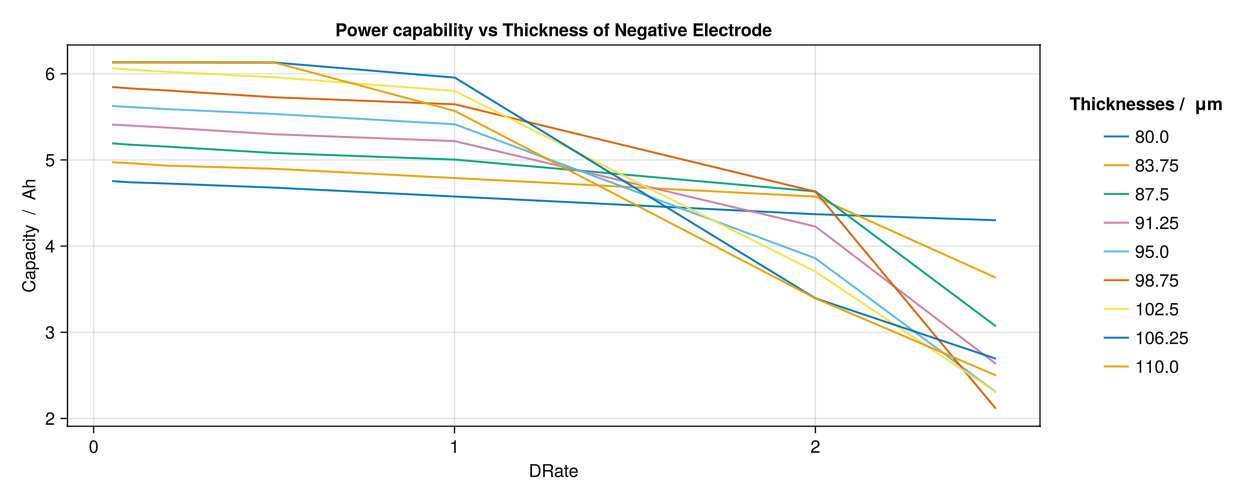

In [53]:
fig = Figure(size = (1000, 400))
ax = Axis(fig[1, 1], title = "Power capability vs Thickness of Negative Electrode",
          xlabel = "DRate", ylabel = "Capacity  /  Ah")

for experiment in power_rates
    label_str = lowercase(string(experiment.thickness*10^6))  # Scientific notation as string
    lines!(ax, experiment.d_rates, experiment.capacities, label = label_str)
end

fig[1, 2] = Legend(fig, ax, "Thicknesses /  μm", framevisible = false)
fig


We can observe in the plot the following feature:
* The cell capacity at low DRates grows quite linerarly with the thickness of the negative electrode up to a point. 
    * The capacity of the negative electrode at thicknesses below 105 um is lower than for the positive electrode. Therefore any increase in negative electrode thickness will increase the overall cell capacity.
    * However, then the thickness of the negative electrode surpass 105 um, additional thickness increase will not translate in additional cell capacity, as the positive electrode capacity becomes the limiting.

The interplay between electrode thicknesses and capacities can be better visualized if we plot the N:P ratios instead of the thicknesses. Lets do this below:

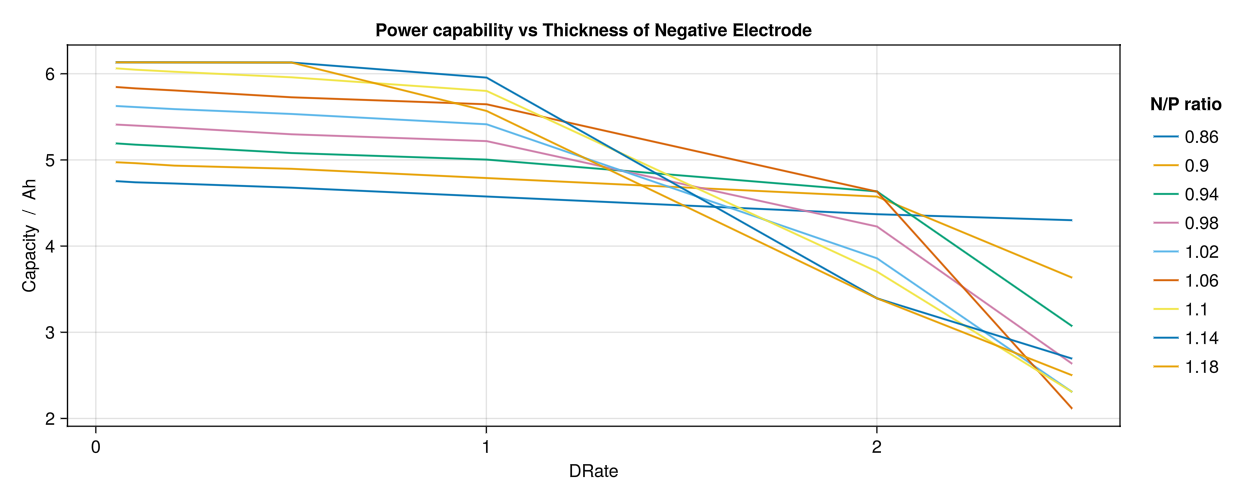

In [54]:
fig = Figure(size = (1000, 400))
ax = Axis(fig[1, 1], title = "Power capability vs Thickness of Negative Electrode",
          xlabel = "DRate", ylabel = "Capacity  /  Ah")

for experiment in power_rates
    label_str = lowercase(string(round(experiment.np_ratios, digits=2)))  # Scientific notation as string
    lines!(ax, experiment.d_rates, experiment.capacities, label = label_str)
end

fig[1, 2] = Legend(fig, ax, "N/P ratio", framevisible = false)
fig

As the N:P ratio slightly exceeds 1.0, the cell capacity at low rate saturates. The saturation does not occur at NP=1.0 exactly, but slightly above 1.1. We think that thickness changes affect the alignment of half-cell OCPs, leading to an actual capacity that differs from that predicted solely by stoichiometric ranges and thicknesses.

At higher rates, we also observe:
* Cell capacities decrease, as overpotentials cause the lower potential limit to be reached before full capacity is delivered.
* This decrease is more pronounced with increasing NP ratios. Thicker electrodes extend the Li⁺ diffusion path within the porous structure, raising transport overpotentials and causing earlier cutoff.

## Part 4 - Rate capability

In this part we will compare the effect that the reaction rate values have on cell performance. Lets start again with loading some pre-defined cell parameters and cycling protocols.

In [55]:
cell_parameters = load_cell_parameters(; from_file_path = "default_sets/cell_parameters/Chen2020.json")
cycling_protocol = load_cycling_protocol(; from_file_path = "default_sets/cycling_protocols/CCDischarge.json")

model_setup = LithiumIonBattery()

✔️ Validation of ModelSettings passed: No issues found.
──────────────────────────────────────────────────


LithiumIonBattery("Setup object for a P2D lithium-ion model", {
    "RampUp" => "Sinusoidal"
    "Metadata" =>     {
        "Description" => "Default model settings for a P2D simulation including a current ramp up, excluding current collectors and SEI effects."
        "Title" => "P2D"
    }
    "TransportInSolid" => "FullDiffusion"
    "ModelFramework" => "P2D"
}, true)

First lets see the effect that the reaction rate of the negative electrode has on cell performance. To do this, we simply loop through
a list of parameter values, carry a simulation for each value, store the outputs, and compare the voltage curves for every output.
We use the logarithm of the reaction rates to change their values by orders of magnitude.

In [56]:
log_rate_start = -3.0
log_rate_stop = -13.0

outputs_rate = []
for r in range(log_rate_start, log_rate_stop, length = 10)
	cell_parameters["NegativeElectrode"]["ActiveMaterial"]["ReactionRateConstant"] = 10^r
	sim = Simulation(model_setup, cell_parameters, cycling_protocol)
	result = solve(sim; config_kwargs = (; end_report = false))
	push!(outputs_rate, (r = r, output = result))  # store r together with output
end

✔️ Validation of CellParameters passed: No issues found.
──────────────────────────────────────────────────
✔️ Validation of CyclingProtocol passed: No issues found.
──────────────────────────────────────────────────
✔️ Validation of SimulationSettings passed: No issues found.
──────────────────────────────────────────────────
Jutul: Simulating 2 hours, 12 minutes as 163 report steps


Progress  40%|██████████████████                         |  ETA: 0:00:00

Progress  69%|██████████████████████████████             |  ETA: 0:00:00

Progress 100%|███████████████████████████████████████████| Time: 0:00:00


✔️ Validation of CellParameters passed: No issues found.
──────────────────────────────────────────────────
✔️ Validation of CyclingProtocol passed: No issues found.
──────────────────────────────────────────────────
✔️ Validation of SimulationSettings passed: No issues found.
──────────────────────────────────────────────────
Jutul: Simulating 2 hours, 12 minutes as 163 report steps


Progress  30%|█████████████                              |  ETA: 0:00:00

Progress  59%|██████████████████████████                 |  ETA: 0:00:01

Progress 100%|███████████████████████████████████████████| Time: 0:00:00


✔️ Validation of CellParameters passed: No issues found.
──────────────────────────────────────────────────
✔️ Validation of CyclingProtocol passed: No issues found.
──────────────────────────────────────────────────
✔️ Validation of SimulationSettings passed: No issues found.
──────────────────────────────────────────────────
Jutul: Simulating 2 hours, 12 minutes as 163 report steps


Progress  38%|█████████████████                          |  ETA: 0:00:00

Progress  73%|████████████████████████████████           |  ETA: 0:00:00

Progress 100%|███████████████████████████████████████████| Time: 0:00:00


✔️ Validation of CellParameters passed: No issues found.
──────────────────────────────────────────────────
✔️ Validation of CyclingProtocol passed: No issues found.
──────────────────────────────────────────────────
✔️ Validation of SimulationSettings passed: No issues found.
──────────────────────────────────────────────────
Jutul: Simulating 2 hours, 12 minutes as 163 report steps


Progress  35%|███████████████                            |  ETA: 0:00:00

Progress  76%|█████████████████████████████████          |  ETA: 0:00:00

Progress 100%|███████████████████████████████████████████| Time: 0:00:00


✔️ Validation of CellParameters passed: No issues found.
──────────────────────────────────────────────────
✔️ Validation of CyclingProtocol passed: No issues found.
──────────────────────────────────────────────────
✔️ Validation of SimulationSettings passed: No issues found.
──────────────────────────────────────────────────
Jutul: Simulating 2 hours, 12 minutes as 163 report steps


Progress  34%|███████████████                            |  ETA: 0:00:00

Progress  73%|████████████████████████████████           |  ETA: 0:00:00

Progress 100%|███████████████████████████████████████████| Time: 0:00:00


✔️ Validation of CellParameters passed: No issues found.
──────────────────────────────────────────────────
✔️ Validation of CyclingProtocol passed: No issues found.
──────────────────────────────────────────────────
✔️ Validation of SimulationSettings passed: No issues found.
──────────────────────────────────────────────────
Jutul: Simulating 2 hours, 12 minutes as 163 report steps


Progress  37%|████████████████                           |  ETA: 0:00:00

Progress  72%|███████████████████████████████            |  ETA: 0:00:00

Progress 100%|███████████████████████████████████████████| Time: 0:00:00


✔️ Validation of CellParameters passed: No issues found.
──────────────────────────────────────────────────
✔️ Validation of CyclingProtocol passed: No issues found.
──────────────────────────────────────────────────
✔️ Validation of SimulationSettings passed: No issues found.
──────────────────────────────────────────────────
Jutul: Simulating 2 hours, 12 minutes as 163 report steps


Progress  43%|███████████████████                        |  ETA: 0:00:00

Progress  90%|███████████████████████████████████████    |  ETA: 0:00:00

Progress 100%|███████████████████████████████████████████| Time: 0:00:00


✔️ Validation of CellParameters passed: No issues found.
──────────────────────────────────────────────────
✔️ Validation of CyclingProtocol passed: No issues found.
──────────────────────────────────────────────────
✔️ Validation of SimulationSettings passed: No issues found.
──────────────────────────────────────────────────
Jutul: Simulating 2 hours, 12 minutes as 163 report steps


Progress  33%|███████████████                            |  ETA: 0:00:00

Progress  87%|██████████████████████████████████████     |  ETA: 0:00:00

Progress 100%|███████████████████████████████████████████| Time: 0:00:00


✔️ Validation of CellParameters passed: No issues found.
──────────────────────────────────────────────────
✔️ Validation of CyclingProtocol passed: No issues found.
──────────────────────────────────────────────────
✔️ Validation of SimulationSettings passed: No issues found.
──────────────────────────────────────────────────
Jutul: Simulating 2 hours, 12 minutes as 163 report steps


Progress  62%|███████████████████████████                |  ETA: 0:00:00

Progress 100%|███████████████████████████████████████████| Time: 0:00:00


✔️ Validation of CellParameters passed: No issues found.
──────────────────────────────────────────────────
✔️ Validation of CyclingProtocol passed: No issues found.
──────────────────────────────────────────────────
✔️ Validation of SimulationSettings passed: No issues found.
──────────────────────────────────────────────────
Jutul: Simulating 2 hours, 12 minutes as 163 report steps


Progress  45%|████████████████████                       |  ETA: 0:00:00

Progress 100%|███████████████████████████████████████████| Time: 0:00:00


Now, plot the discharge curves for each reaction rate:

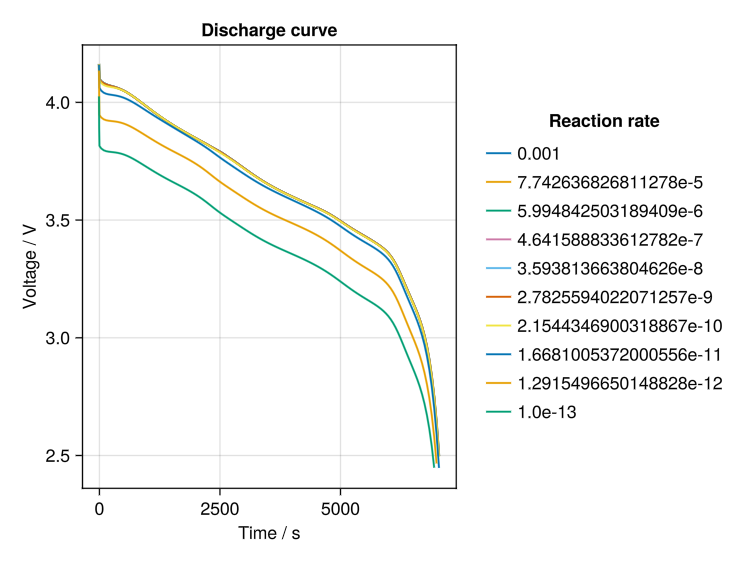

In [57]:
fig = Figure()
ax = Axis(fig[1, 1], ylabel = "Voltage / V", xlabel = "Time / s", title = "Discharge curve")

for data in outputs_rate
	time_series = get_output_time_series(data.output)
	t = time_series[:Time]
	E = time_series[:Voltage]
	label_str = lowercase(string(10^data.r))
	lines!(ax, t, E, label = label_str)
end

fig[1, 2] = Legend(fig, ax, "Reaction rate", framevisible = false)
fig

Sweeping reaction rates result in interesting behavior of the cells voltage and capacity. High reaction rates have negligible influence 
on the cell voltage curve. However, values below 1e-10 result in a noticeable difference on the curves and the cell's capacity. 
This observations might be attributed to the interplay between Li+ diffusion and reaction processes. For high reaction rates, 
the limiting Li+ transport step might be diffusing Li+ from/to the electrodes. However, below a threshold value, the reaction kinetics 
becomes the bottleneck step in Li+ transport, thus contributing significantly to the cell's overpotential. 

Lets now see the effect that the diffusion coefficient of the positive electrode has on cell performance. We first set the reaction rate 
to the original value in the parameter set, and then follow the same procedure as above.

✔️ Validation of CellParameters passed: No issues found.
──────────────────────────────────────────────────
✔️ Validation of CyclingProtocol passed: No issues found.
──────────────────────────────────────────────────
✔️ Validation of SimulationSettings passed: No issues found.
──────────────────────────────────────────────────
Jutul: Simulating 2 hours, 12 minutes as 163 report steps


Progress  48%|█████████████████████                      |  ETA: 0:00:00

Progress 100%|███████████████████████████████████████████| Time: 0:00:00


✔️ Validation of CellParameters passed: No issues found.
──────────────────────────────────────────────────
✔️ Validation of CyclingProtocol passed: No issues found.
──────────────────────────────────────────────────
✔️ Validation of SimulationSettings passed: No issues found.
──────────────────────────────────────────────────
Jutul: Simulating 2 hours, 12 minutes as 163 report steps


Progress  40%|██████████████████                         |  ETA: 0:00:00

Progress 100%|███████████████████████████████████████████| Time: 0:00:00


✔️ Validation of CellParameters passed: No issues found.
──────────────────────────────────────────────────
✔️ Validation of CyclingProtocol passed: No issues found.
──────────────────────────────────────────────────
✔️ Validation of SimulationSettings passed: No issues found.
──────────────────────────────────────────────────
Jutul: Simulating 2 hours, 12 minutes as 163 report steps

Progress  27%|████████████                               |  ETA: 0:00:00



Progress  80%|███████████████████████████████████        |  ETA: 0:00:00

Progress 100%|███████████████████████████████████████████| Time: 0:00:00


✔️ Validation of CellParameters passed: No issues found.
──────────────────────────────────────────────────
✔️ Validation of CyclingProtocol passed: No issues found.
──────────────────────────────────────────────────
✔️ Validation of SimulationSettings passed: No issues found.
──────────────────────────────────────────────────
Jutul: Simulating 2 hours, 12 minutes as 163 report steps


Progress  23%|██████████                                 |  ETA: 0:00:00

Progress  79%|███████████████████████████████████        |  ETA: 0:00:00

Progress 100%|███████████████████████████████████████████| Time: 0:00:00


✔️ Validation of CellParameters passed: No issues found.
──────────────────────────────────────────────────
✔️ Validation of CyclingProtocol passed: No issues found.
──────────────────────────────────────────────────
✔️ Validation of SimulationSettings passed: No issues found.
──────────────────────────────────────────────────
Jutul: Simulating 2 hours, 12 minutes as 163 report steps


Progress  51%|██████████████████████                     |  ETA: 0:00:00

Progress 100%|███████████████████████████████████████████| Time: 0:00:00


✔️ Validation of CellParameters passed: No issues found.
──────────────────────────────────────────────────
✔️ Validation of CyclingProtocol passed: No issues found.
──────────────────────────────────────────────────
✔️ Validation of SimulationSettings passed: No issues found.
──────────────────────────────────────────────────
Jutul: Simulating 2 hours, 12 minutes as 163 report steps


Progress  27%|████████████                               |  ETA: 0:00:00

Progress  79%|███████████████████████████████████        |  ETA: 0:00:00

Progress 100%|███████████████████████████████████████████| Time: 0:00:00


✔️ Validation of CellParameters passed: No issues found.
──────────────────────────────────────────────────
✔️ Validation of CyclingProtocol passed: No issues found.
──────────────────────────────────────────────────
✔️ Validation of SimulationSettings passed: No issues found.
──────────────────────────────────────────────────
Jutul: Simulating 2 hours, 12 minutes as 163 report steps


Progress  24%|███████████                                |  ETA: 0:00:00

Progress  81%|███████████████████████████████████        |  ETA: 0:00:00

Progress 100%|███████████████████████████████████████████| Time: 0:00:00


✔️ Validation of CellParameters passed: No issues found.
──────────────────────────────────────────────────
✔️ Validation of CyclingProtocol passed: No issues found.
──────────────────────────────────────────────────
✔️ Validation of SimulationSettings passed: No issues found.
──────────────────────────────────────────────────
Jutul: Simulating 2 hours, 12 minutes as 163 report steps


Progress  19%|█████████                                  |  ETA: 0:00:01

Progress  67%|█████████████████████████████              |  ETA: 0:00:00

Progress 100%|███████████████████████████████████████████| Time: 0:00:00


✔️ Validation of CellParameters passed: No issues found.
──────────────────────────────────────────────────
✔️ Validation of CyclingProtocol passed: No issues found.
──────────────────────────────────────────────────
✔️ Validation of SimulationSettings passed: No issues found.
──────────────────────────────────────────────────
Jutul: Simulating 2 hours, 12 minutes as 163 report steps


Progress  33%|███████████████                            |  ETA: 0:00:01

Progress  81%|███████████████████████████████████        |  ETA: 0:00:00

Progress 100%|███████████████████████████████████████████| Time: 0:00:00


✔️ Validation of CellParameters passed: No issues found.
──────────────────────────────────────────────────
✔️ Validation of CyclingProtocol passed: No issues found.
──────────────────────────────────────────────────
✔️ Validation of SimulationSettings passed: No issues found.
──────────────────────────────────────────────────
Jutul: Simulating 2 hours, 12 minutes as 163 report steps


Progress  48%|█████████████████████                      |  ETA: 0:00:00

Progress 100%|███████████████████████████████████████████| Time: 0:00:00


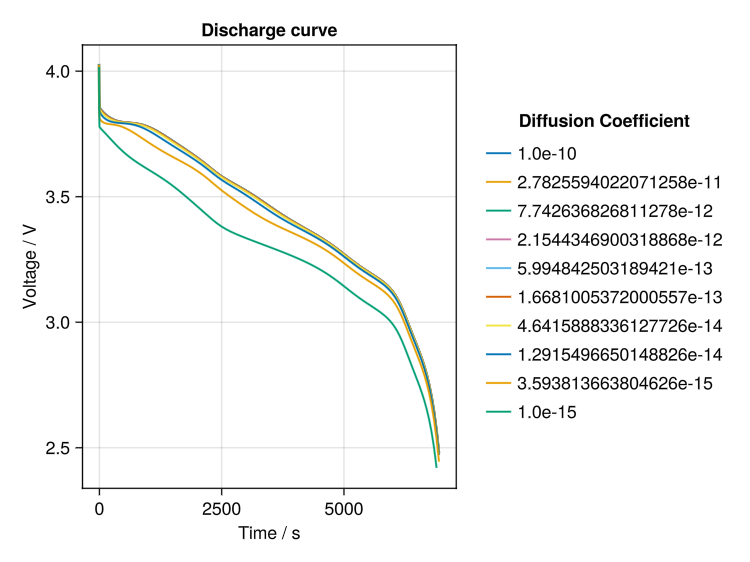

In [58]:
cell_parameters["NegativeElectrode"]["ActiveMaterial"]["ReactionRateConstant"] = 1.0e-13

log_D_start = -10.0
log_D_stop = -15.0

outputs_diff = []

for d in range(log_D_start, log_D_stop, length = 10)
	cell_parameters["PositiveElectrode"]["ActiveMaterial"]["DiffusionCoefficient"] = 10^d
	sim = Simulation(model_setup, cell_parameters, cycling_protocol)
	result = solve(sim; config_kwargs = (; end_report = false))
	push!(outputs_diff, (d = d, output = result))  # store r together with output
end


fig1 = Figure()
ax1 = Axis(fig1[1, 1], ylabel = "Voltage / V", xlabel = "Time / s", title = "Discharge curve")

for data in outputs_diff
	if length(data.output[:states]) > 0 #if simulation is successful
		time_series = get_output_time_series(data.output)
		t = time_series[:Time]
		E = time_series[:Voltage]
		label_str = lowercase(string(10^data.d))
		lines!(ax1, t, E, label = label_str)
	end
end

fig1[1, 2] = Legend(fig1, ax1, "Diffusion Coefficient", framevisible = false)
fig1

Diffusion coefficients, just as reaction rates, have also a non-linear effect on the cells voltage and capacity. Diffusion coefficients down to 5e-14  have negligible influence on the cell voltage curve. However, as the coefficients fall below 5e-14 they start to influence the curves and the cell's capacity in a noticeable way. The effect becomes more pronounced at lower values. As with reaction rates, these observations might originate from the interplay between Li+ diffusion and reaction processes, where the cell's overpotential responds to the transport limiting step.